# Chinese Restaurants Analysis on Yelp Data
### STAT 628 Thursday Group 6

# 1. Introduction

Based on the reviews and restaurant information from yelp, we aim to provide useful and analytic insights to business owners. Here we are most interested in 4434 Chinese restaurants and want to help them to make data-driven decisions to improve their ratings on yelp. Also, we build a Rshiny Application to give a more vivid explanation.

# 2. Data Selection and Pre-processing

There are 192,609 businesses and 6,685,900 reviews. Firstly, we merged "review.json", "tip.json" and "business.json" three files into one file, named "Total_restaurant.json", according to "business_id". Secondly, we extracted the data which has "Chinese", "Restaurant", "Food" in their attributes, since we are interested in Chinese restauratns. Then, we got the data "Chinese_restaurant.json", which has 4434 Chinese restaurants and 261566 reviews.

For the reviews part, we split them into words, remove punctuation, convert words to lower cases and remove stop words(except "nor", "not", "no").

For business part,  we mainly focused on the relationship between stars and business attributes. Firstly we deleted 156 restaurants wiht no attribute, since these observations can not help us analyze the data. Then, we extracted the main attributes and sub-attribuets in each main attributes as new columns. In addition, we transfer the value into string and write a new file "Attributes.csv".


# 3. Attributes Analysis

For the business attributes data, we had 71 features in total. Since some features only have one level, such as "AcceptsInsurance","BYOB","AgesAllowed" and so on, which do not help us analyze the data, we just drop these 11 features. Then we want to analyze the relationship between stars and remaining 60 features.

Since there are too many missing values, it is difficult to use a linear model to find the important features. Thus, we consider to use a tree model to analyze it. We applied GUIDE algorithm, which is an algorithm for construction of classification and regression trees and forests, to analyze the data with missing values, since GUIDE is automatic handling of missing values without requiring prior imputation. From the GUIDE importance score output, we selected the most important 10 features among all of the features, which are "NoiseLevel", "RestaurantsGoodForGroups", "Ambience" including "casual", "trendy" and "intimate", "GoodForMeal" including "dinner", "lunch", "brunch", "latenight" and "breakfast". 

For these 10 features, we treat the missing data as a new level 0 in each feature. Then we performed a one-way ANOVA for each feature. All of the 10 features are significant at the significance level of 0.05. In addition, we performed multiple comparisons by Bonferroni method to find whether the different levels of an exact feature have an effect on the stars of a restaurant. For example, from the hypothesis test results of feature "casual", we find that the stars of each level are different groups. In addition, the stars of these three levels satisfy True > False > Missing.

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Plots code."></form>''')

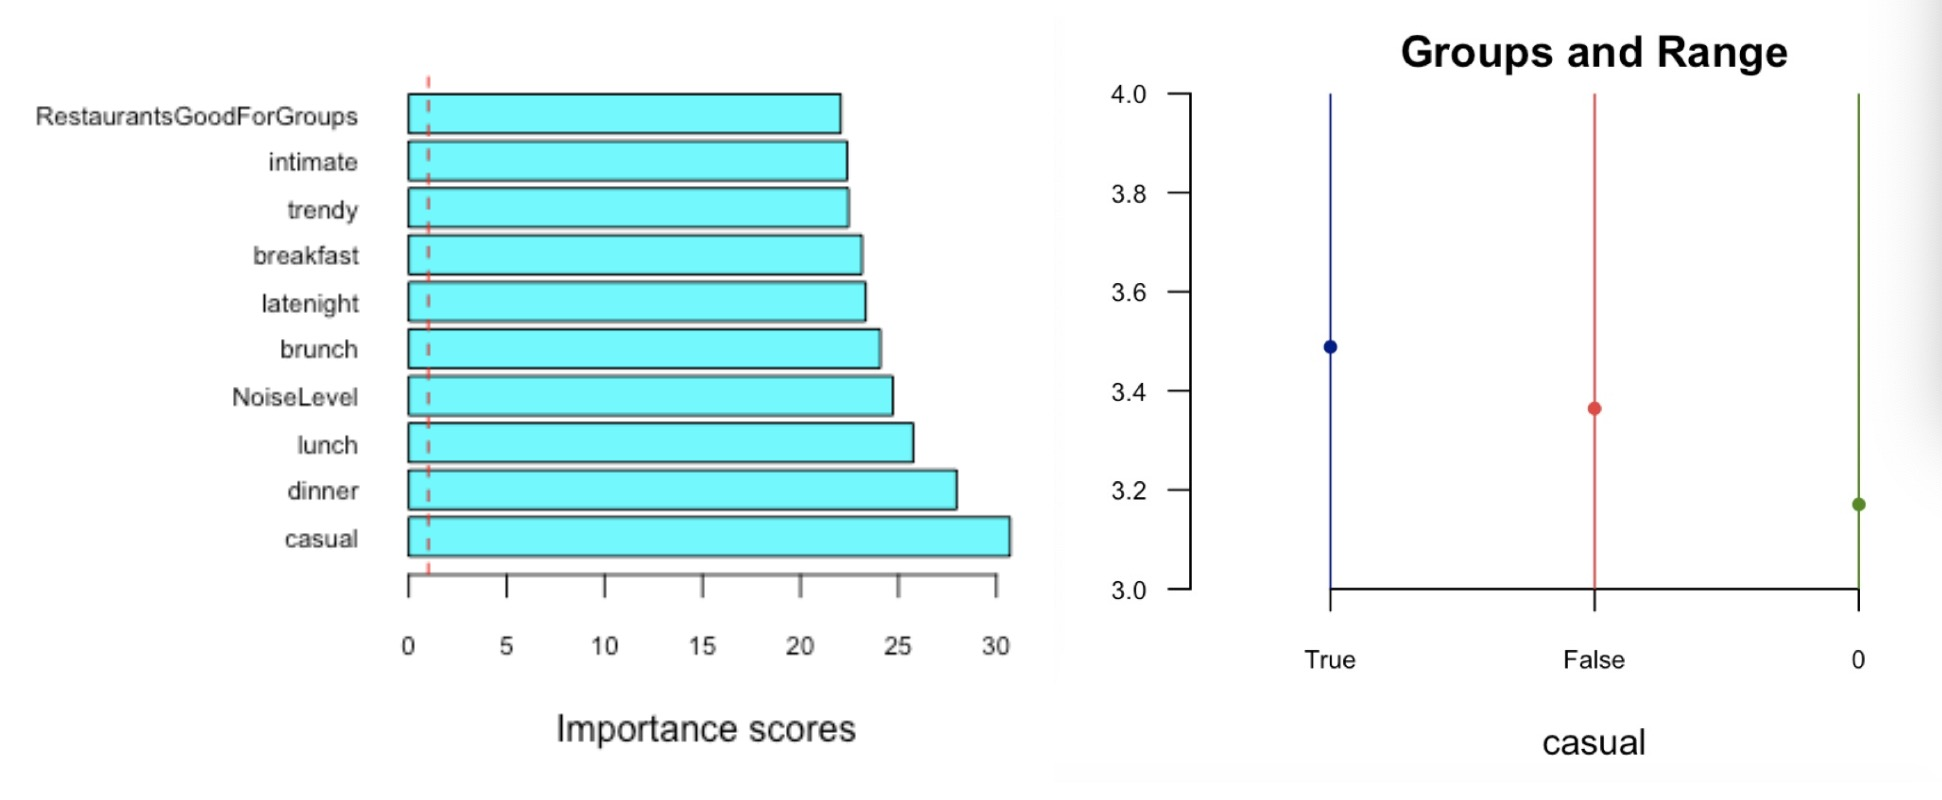

In [21]:
display(Image(filename='/Users/hewishwang/Desktop/stat_479_tree/628useGuide/attribute_plots.jpg'))

From the analysis above, we figure out that a Chinese restaurant tends to get lower rating if some of above 10 attributes are missing. We think maybe these attributes can help customers to determine whether a restaurant can meet their needs or not. If the business owners do not provide these information, some unexpected things may occur, which could result in bad reviews. For example, if you go to a restaurant without the "RestaurantsGoodForGroups" information on Yelp, you have 5 people in total, but the restaurant could only provide tables for at most four, which could result in a negative review. 

These 10 attributes can be merged in 4 main attributes, that is, "Ambience", "GoodForMeal", "NoiseLevel" and "RestaurantsGoodForGroups". We will give suggestions on our shiny app for each restaurant based on above analysis.


# 4. Reviews Analysis

We mainly focus on two parts from the reviews. One is "overall service", the other is "food". We'd like to search for words and phrases on these two fields. Totally, we find 3 "service" features and 34 "food" features. Regard user' rating as labels, and use lasso Regression to see the correlation between these words features and the rating. Thus, we can give some advices based on analysis. 

### 4.1 Overall Service

More specifically, we try to get the "service" information from three sub aspects: (1) waiting time (2) service from waiter (3) price. In order to get these information, we need to identify the words which represent the three aspect.

We first choose some nouns from top 200 nouns in reviews, then classify them into one of the three aspects. The words we selected are:

* "waiting": wait, waiting;

* "service": waiter, waitress, staff, serve, service, services, server, servers;

* "price": paid, price,prices,pay, money, bill;

Among all the reviews, the "waiting" words appear in 26335 reviews, "service" words appear in 124042 reviews, "price" words appear in 63837 reviews. So in genearal, customers are more likely to make comments on service and price.

#### Intuition Description:
To get some intuitive descriptions of the three aspects, we work to identify the adj/adv related to these words. Here, we use the pos_tag function from NLTK to get a tag for a word. To find adj/adv for a noun, we first judge whether the word before the noun is a adj/adv. If it is, that word is our target and stop finding; if isn't, we start to look for adj/adv after this noun, until we reach a non-adj/adv word. We should note that, some businesses have little reviews so that it can not find any adj/adv, or just can find adj/adv for one aspesct.

For each business, we combine the adj/adv for one aspect together, calculate the word frequency, and then display these adj/adv as intuitive descriptions on our Shiny App. We also list some examples following:

**Example 1** Description words for business with high rating: "Tott's Asian Diner", stars: 4.0, 328 Positive Reviews, 105 Negative Reviews.

  **wait:** [('short', 3)],  

  **service:** [('friendly', 47), ('great', 29), ('good', 8), ('nice', 6), ('attentive', 2), ('bad', 1)], 

  **price:** [('reasonable', 11), ('good', 8), ('great', 8), ('bad', 2)]
 
**Example 2** Description words for business with low rating: "Emerald Chinese Restaurant", stars: 2.5, 45 Positive Reviews, 89 Negative Reviews.

**wait:** [('long', 4), ('short', 1)],  

**service:** [('good', 11), ('poor', 6), ('bad', 6), ('terrible', 3), ('friendly', 3), ('horrible', 3), ('pretty', 2), ('great', 2), ('attentive', 2), ('nice', 1)] 

**price:** [('higher', 3), ('reasonable', 3), ('high', 2), ('good', 1), ('expensive', 1)]


For the restaurant with low ratings, negative words take a large propotion when making comments on service, also price is high for many customers.


#### Convert the words to a X-matrix.

Beside the intuition description, we further hope to use a regression model to quantify the effects of wait/service/price. For each review, if the word related to "wait" appears, we denote it as "1", otherwise "0". Same procedure for "service" and "price". So we get a vector with 3 elements to describe each review. 

### 4.2 Food Analysis

As we all know, the food offered by Chinese restaurants are various. The first question here is how to extract the useful food names as the features.

Based on the visualization of review data, we find the some food names always occur as Bigram or Trigram. When we see the frequency distribution of Bigram and Trigram, we find many comman Chinese restaurant food in the top rating. For example:


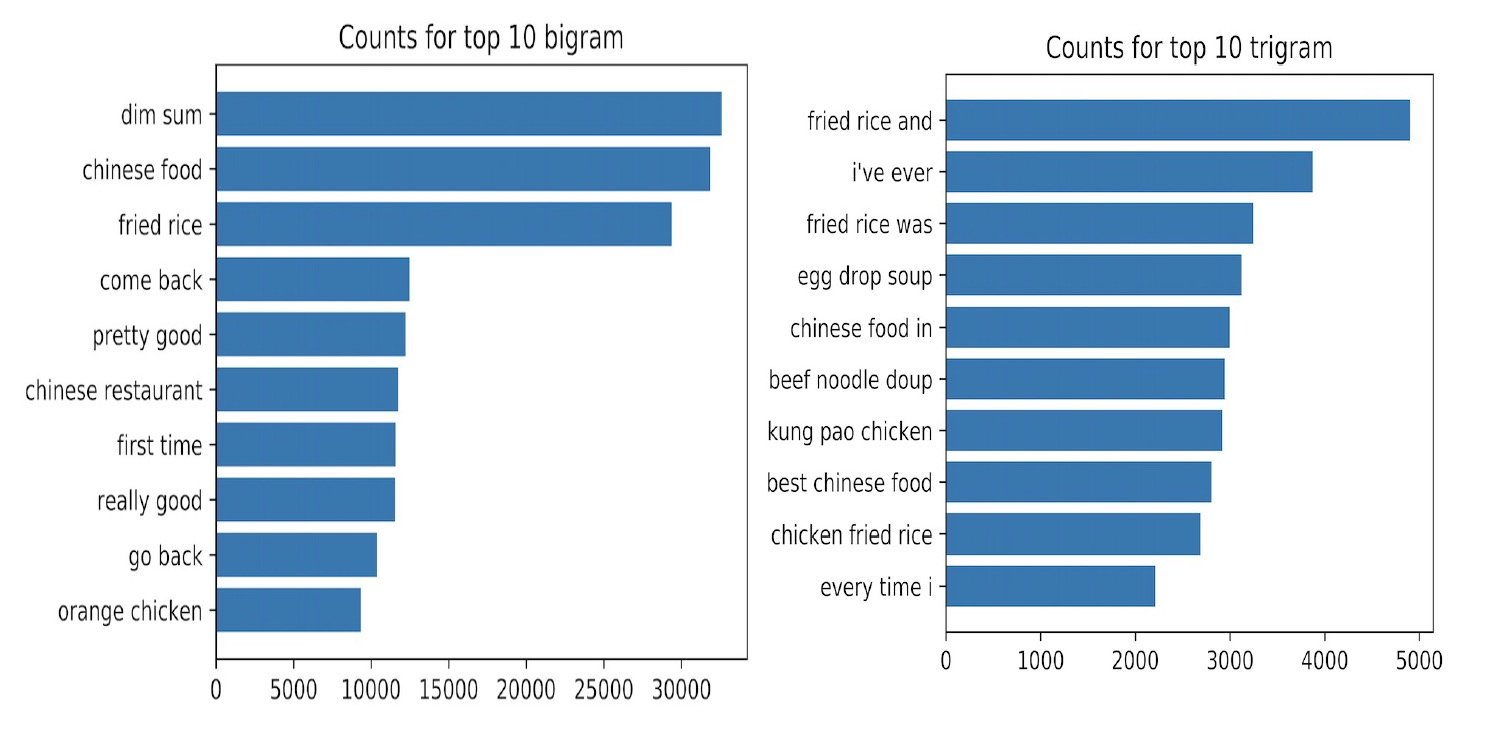

In [20]:
display(Image(filename='/Users/hewishwang/Desktop/stat 628/module 3/bi&tri.jpg'))

We can see "dim sum" is top one in Bigram frequency distribution, and "egg drop soup" is the fourth in Trigram frequency distribution. 

Thus, we scan the top 100 Bigram and Trigram frequency distribution, and manually find 24 Bigram food phrases and 10 Trigram food phrases. 

**Bigram:** [('dim','sum'), ('fried','rice'), ('orange', 'chicken'), ('chow', 'mein'), ('pad', 'thai'), ('sour', 'soup'), ('hot', 'pot'), ('spring', 'rolls'), ('lo', 'mein'), ('bbq', 'pork'), ('mongolian', 'beef'), ('egg', 'roll'), ('wonton', 'soup'), ('soy', 'sauce'), ('ice', 'cream'), ('pork', 'belly'), ('milk', 'tea'), ('fried', 'chicken'),  ('sour', 'chicken'), ('white', 'rice'), ('sesame', 'chicken'), ('chicken', 'wings'), ('peking', 'duck'), ('bubble', 'tea')]

**Trigram:** [('egg', 'drop', 'soup'), ('beef', 'noodle', 'soup'), ('kung', 'pao', 'chicken'), ('chicken', 'fried', 'rice'), ('pork', 'fried', 'rice'), ('black', 'bean', 'sauce'), ('shrimp', 'fried', 'rice'), ('xiao', 'long', 'bao'), ('egg', 'foo', 'young'), ('dan', 'dan', 'noodles')]

Then, for every review, we construct a 34 dimensional vector, if the food phrase appears in a review, the element in corresponding position will be 1. We can get the final imput byb combining the food data and service data.

### 4.3 Lasso Regression

At first, we take the Logistic Regression into account. And regard the 5 level user rating as labels, or regard 3,4,5 star as positive and 1,2 star as negative. However, some business only have several reviews and all the rating are 1 or 2 star. We can't find a same standard to divide the label for every business. 

Finally, we choose the linear regression. Provided with the small amount of reviews of some businesses and the sparse dataset, we'd like to use lasso regression to reduce the number of variables in each model. Thus, we can give the advices based on the model coefficients. For the highest coefficient food, we want to encourage the restaurant owner offer more. For the lowest coefficient food, we'd like to alert the restaurant owner to improve the quantity. For the service , if the coefficient is negative, we need to remind the restaurant owner of this field. 

For example, for Emerald Chinese Restaurant. We have 134 reviews. Using Lasso Regression to fit the data, we get the formula:

$$Y = -0.12 * service - 0.36 * price + 0.75 * ("dim", "sum") - 0.36 * ("fried","rice")$$

Thus, we can give the advice like this:

**Emerald Chinese Restaurant:** 

1. Your ("dim", "sum") is fond of customers, so you should keep the flavor.

2. Your ("fried","rice") more or less has a bad effect on your Yelp rating, so you should improve its recipe or remove ("fried","rice") from your menu.

3. Your service lowers your Yelp rating, so you should improve your waiters’ service level

4. Your price lowers your Yelp rating, so you should cut your price.


# 5. Pros and Cons

## Pros 

* For business data, we use GUIDE classification tree model on business attributes, which help us avoid missing data imputation. In addition, the Bonferroni method makes the multiple comparisons reliable.
* We take full advantage of the information from reviews. We select 3 overall service features and 34 food phrase features which can mostly describe opinions from different customers.
* For some business which have few reviews, we use lasso regression to avoid the influence of sparse data.
* Give specific advices based on attributes and reviews.

## Cons

* We build two models based on attributes and reviews separately, and give advices from two different perspective. 
* On review analysis section, there are some reviews have no chosen word features, which means their elements in the vector are all zero. In that case, we can't get useful imformation from that review except its user rating.


# Contribution

* Yun Mo: Reviews Cleaning, Reviews Analysis, Choosing words, phrases among reviews
* He Wang: Data Preprocessing, Tree Model Construction, All Restaurant Data Description
* Zifeng Wang: Reviews Cleaning, Reviews Analysis, Generate Advice for business onwer
* Qintao Ying: Rshiny, Data Cleaning, Chinese Restaurant Data Description